# Lab: Retraining a pre-trained model
We will retrain a pre-trained model to classify cats-and-dogs!

### Runtime
~ 30 minutes

### Note
Here we are dealing with real world images.  Processing them will required a lot of compute power.  
If you have access to, switch to **GPU** as run time!

### References
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.learnopencv.com/keras-tutorial-using-pre-trained-imagenet-models/

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print ('tensorflow version :', tf.__version__)
tf.config.experimental.list_physical_devices()

tensorflow version : 2.2.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [2]:
## Add top level dir to include path
import os
import sys
from pathlib import Path

top_dir = os.path.abspath(Path(os.getcwd()).parent)
if top_dir not in sys.path:
    sys.path.append(top_dir)

## TF-GPU Config
The following cell sets TF properties to run on GPU

In [3]:
## This block is to tweak TF running on GPU
## You may comment this out, if you are not using GPU

## ---- start Memory setting ----
## Ask TF not to allocate all GPU memory at once.. allocate as needed
## Without this the execution will fail with "failed to initialize algorithm" error

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Step 1 - Download Data
We will use cat-dog-redux dataset

In [4]:
## Common constants

IMG_WIDTH=160
IMG_HEIGHT=160
NUM_CLASSES=2
BATCH_SIZE=64
APP_NAME = 'retrain'
EPOCHS = 3

In [5]:
import os

data_location = 'https://elephantscale-public.s3.amazonaws.com/data/images/cat-dog-redux.zip'

data_location_local = keras.utils.get_file(fname=os.path.basename(data_location),
                                           origin=data_location, extract=True)
print ('local download file: ', data_location_local)
data_dir = os.path.join(os.path.dirname(data_location_local), 'cat-dog-redux')
print ('local data dir: ', data_dir)
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
print ('train dir:', train_dir)
print ('validation dir:', validation_dir)

local download file:  /home/sujee/.keras/datasets/cat-dog-redux.zip
local data dir:  /home/sujee/.keras/datasets/cat-dog-redux
train dir: /home/sujee/.keras/datasets/cat-dog-redux/train
validation dir: /home/sujee/.keras/datasets/cat-dog-redux/val


## Step 2 - Setup Data Generators

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=45,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True)


validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical'
                                                          )


val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical'
                                                             )

Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


## Step 3 - Download Model
Let's try the InceptionV3 model.  We will only download the 'base' model, without the final classifying layers

In [7]:
from transfer_learning_utils import print_model_summary_compact

pre_trained_model = tf.keras.applications.InceptionV3(input_shape=(IMG_WIDTH,IMG_HEIGHT,3), 
                                               include_top = False,
                                               weights = 'imagenet')
print_model_summary_compact(pre_trained_model)
print ()

! du -skh ~/.keras/models/* | grep inception

* Model: "inception_v3"
* Total params: 21,802,784
* Trainable params: 21,768,352
* Non-trainable params: 34,432
* # layers:  311

92M	/home/sujee/.keras/models/inception_v3_weights_tf_dim_ordering_tf_kernels.h5
84M	/home/sujee/.keras/models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [8]:
# pre_trained_model.summary()  # large output

### Inspect the model and freeze the layers

In [9]:
# last_layer = pre_trained_model.get_layer('mixed7')
last_layer = pre_trained_model.layers[-1]

print ("last_layer.name:", last_layer.name)
print ('last_layer.output.shape:', last_layer.output_shape)

last_layer.name: mixed10
last_layer.output.shape: (None, 3, 3, 2048)


In [10]:
## Freeze all layers
# for layer in pre_trained_model.layers:
#   layer.trainable = False

# or this works too
pre_trained_model.trainable = False

print_model_summary_compact (pre_trained_model)

* Model: "inception_v3"
* Total params: 21,802,784
* Trainable params: 0
* Non-trainable params: 21,802,784
* # layers:  311


## Step 4 - Create our own model

We are going to add a ccouple of layers
- One fully connected layer
- And a softmax layer

On top of the model

* Model: "sequential_1"
* Total params: 31,241,506
* Trainable params: 9,438,722
* Non-trainable params: 21,802,784
* # layers:  5



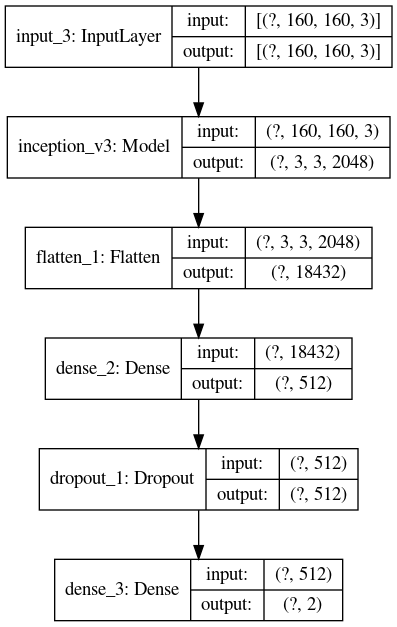

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Softmax, Flatten, GlobalAveragePooling2D, Dropout
from transfer_learning_utils import print_model_summary_compact

model = Sequential ([
                Input (shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
                pre_trained_model, 
                Flatten(), 
                #GlobalAveragePooling2D(),
                Dense(512, activation='relu'),
                Dropout(0.5),
                Dense(NUM_CLASSES, activation='softmax')
            ])

model.compile (loss='categorical_crossentropy',
                  optimizer= 'adam',
                  metrics=['accuracy'])

print_model_summary_compact(model)
print()
# my_model.summary()  # large output

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## Step 5 - Setup Tensorboard

In [12]:
## This is fairly boiler plate code

import datetime
import os
import shutil

app_name = APP_NAME


# timestamp  = datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

tb_top_level_dir= '/tmp/tensorboard-logs'

tb_app_dir = os.path.join (tb_top_level_dir, app_name)

tb_logs_dir = os.path.join (tb_app_dir, datetime.datetime.now().strftime("%H-%M-%S"))


print ("Saving TB logs to : " , tb_logs_dir)

#clear out old logs
shutil.rmtree ( tb_app_dir, ignore_errors=True )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_logs_dir, write_graph=True, 
                                                      write_images=True, histogram_freq=1)

## This will embed Tensorboard right here in jupyter!
# ! killall tensorboard  # kill previously running tensorboards
%load_ext tensorboard
%tensorboard --logdir $tb_logs_dir

Saving TB logs to :  /tmp/tensorboard-logs/retrain/20-38-12


## Step 6 : Train

In [13]:
%%time 

steps_per_epoch = train_data_gen.n // train_data_gen.batch_size
validation_steps = val_data_gen.n // val_data_gen.batch_size
print ('steps_per_epocoh:', steps_per_epoch)
print ('validation_steps:', validation_steps)

history = model.fit(
    train_data_gen,
    steps_per_epoch= steps_per_epoch,
    epochs=10,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    callbacks = [tensorboard_callback]
)

steps_per_epocoh: 7
validation_steps: 7
Epoch 1/10
7/7 [==============================] - 6s 826ms/step - loss: 29.5414 - accuracy: 0.5402 - val_loss: 2.2663 - val_accuracy: 0.8884
Epoch 2/10
7/7 [==============================] - 5s 697ms/step - loss: 5.6050 - accuracy: 0.7982 - val_loss: 0.7580 - val_accuracy: 0.9353
Epoch 3/10
7/7 [==============================] - 5s 737ms/step - loss: 2.4032 - accuracy: 0.8670 - val_loss: 0.8108 - val_accuracy: 0.9554
Epoch 4/10
7/7 [==============================] - 5s 729ms/step - loss: 1.6215 - accuracy: 0.8991 - val_loss: 0.5320 - val_accuracy: 0.9576
Epoch 5/10
7/7 [==============================] - 5s 727ms/step - loss: 1.1982 - accuracy: 0.9083 - val_loss: 0.4356 - val_accuracy: 0.9554
Epoch 6/10
7/7 [==============================] - 5s 723ms/step - loss: 0.9206 - accuracy: 0.9197 - val_loss: 0.4140 - val_accuracy: 0.9554
Epoch 7/10
7/7 [==============================] - 5s 729ms/step - loss: 0.6340 - accuracy: 0.9220 - val_loss: 0.1619 - 

### Save the model for reuse later
As you can see training takes a long time.  
Let's save the resulting model, so we can use it quickly without going through training again.

In [27]:
import os

model_file =  APP_NAME + '-model.h5'
model.save(model_file)

model_size_in_bytes = os.path.getsize(model_file)
print ("model saved as '{}',  size = {:,f} bytes / {:,.1f} KB  / {:,.1f} MB".format(model_file, 
                                    model_size_in_bytes, model_size_in_bytes / 1e3, 
                                    model_size_in_bytes / 1e6 ))

model saved as 'retrain-model.h5',  size = 125,465,520.000000 bytes / 125,465.5 KB  / 125.5 MB


## Step 7 : See Training History

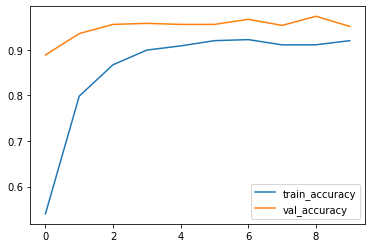

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Step 8 : Evaluate the Model 

### 8.1 - Metrics

In [16]:
from math import ceil


metrics = model.evaluate(val_data_gen, batch_size=val_data_gen.batch_size, steps=ceil(val_data_gen.n // val_data_gen.batch_size) )

metric_names = model.metrics_names
print ("model metrics : " , metric_names)

for idx, metric in enumerate(metric_names):
    print ("Metric : {} = {:,.3f}".format (metric_names[idx], metrics[idx]))

7/7 [==============================] - 1s 82ms/step - loss: 0.1140 - accuracy: 0.9576
model metrics :  ['loss', 'accuracy']
Metric : loss = 0.114
Metric : accuracy = 0.958


### 8.2 - Predictions and Confusion Matrix

In [22]:
import numpy as np
from math import ceil


print ("predicting on {:,} test images".format(val_data_gen.n))
# we need a ceiling for steps
predictions = model.predict(val_data_gen, batch_size=val_data_gen.batch_size, 
                            steps=ceil(val_data_gen.n / val_data_gen.batch_size) )
print( 'predictions.shape: ', predictions.shape)


if val_data_gen.class_mode == 'categorical':
    # converting softmax --> classes
    print ("convering softmax --> classes")
    predictions2 = [ np.argmax(p) for p in predictions]

if val_data_gen.class_mode == 'binary':
    # converting sigmoid --> classes
    print ("converting sigmod --> binary")
    predictions2 = [0 if n < 0.5 else 1 for n in predictions]


# ## Ensure all predictions match
assert(len(predictions) == len(predictions2) == len(val_data_gen.classes) )

predicting on 500 test images
predictions.shape:  (500, 2)
convering softmax --> classes


In [18]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

print ('predictions : ' , predictions[:10])
print ('prediction2: ' , predictions2[:10])

predictions :  [[ 1.00  0.00]
 [ 0.00  1.00]
 [ 1.00  0.00]
 [ 0.00  1.00]
 [ 0.00  1.00]
 [ 0.00  1.00]
 [ 1.00  0.00]
 [ 0.00  1.00]
 [ 1.00  0.00]
 [ 1.00  0.00]]
prediction2:  [0, 1, 0, 1, 1, 1, 0, 1, 0, 0]


In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_labels = val_data_gen.classes
cm = confusion_matrix(test_labels, predictions2, labels = range(0, NUM_CLASSES))
cm

array([[111, 139],
       [118, 132]])

class index mapping :  {'cat': 0, 'dog': 1}


[]

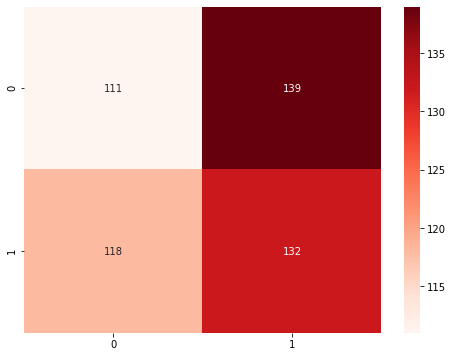

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

print ("class index mapping : ", val_data_gen.class_indices)

plt.figure(figsize = (8,6))

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm, annot=True, cmap="Reds", fmt='d').plot()

## Cleanup 
Before running the next exercise, run the following cell to terminate processes and free up resources

In [21]:
## Kill any child processes (like tensorboard)

import psutil
import os, signal

current_process = psutil.Process()
children = current_process.children(recursive=True)
for child in children:
    print('Killing Child pid  {}'.format(child.pid))
    os.kill(child.pid, signal.SIGKILL)
    
## This will kill actual kernel itself
# os.kill(os.getpid(), signal.SIGKILL)

Killing Child pid  22815
